In [183]:
import numpy as np 
import matplotlib.pyplot as plt


In [184]:
def l2_diff(f1, f2):
    """
    Computes the l2-norm of the difference
    between a function f1 and a function f2
    
    Parameters
    ----------
    f1 : array of floats
        function 1
    f2 : array of floats
        function 2
    
    Returns
    -------
    diff : float
        The l2-norm of the difference.
    """
    l2_diff = np.sqrt(np.sum((f1 - f2)**2))/f1.shape[0]
    
    return l2_diff

In this problem, we investigate the Poisson equation: 
$$ 
\nabla^2 p(x,y) = b(x,y)
$$
where 
$$
b(x,y) = \sin(\pi x)\cos(\pi y) + \sin(5\pi x)\cos (5\pi y)
$$
whose exact solution is known analytically
$$
p_e = -\frac{1}{2\pi^2}\sin(\pi x)\cos(\pi y) - \frac{1}{50\pi ^2}\sin(5\pi x)\cos(5\pi y)
$$

In [185]:
# Grid parameters.
nx = 101                  # number of points in the x direction
ny = 101                  # number of points in the y direction
xmin, xmax = 0.0, 1.0     # limits in the x direction
ymin, ymax = -0.5, 0.5    # limits in the y direction
lx = xmax - xmin          # domain length in the x direction
ly = ymax - ymin          # domain length in the y direction
dx = lx / (nx-1)          # grid spacing in the x direction
dy = ly / (ny-1)          # grid spacing in the y direction

In [186]:
# Create the gridline locations and the mesh grid;
# see notebook 02_02_Runge_Kutta for more details
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
# We pass the argument `indexing='ij'` to np.meshgrid
# as x and y should be associated respectively with the
# rows and columns of X, Y.
X, Y = np.meshgrid(x, y, indexing='ij')

# Compute the rhs. Note that we non-dimensionalize the coordinates
# x and y with the size of the domain in their respective dire-
# ctions.
b = (np.sin(np.pi*X)*np.cos(np.pi*Y)
  + np.sin(5.0*np.pi*X)*np.cos(5.0*np.pi*Y))


# Allocate array for the (full) solution, including boundary values
p = np.empty((nx, ny))

In [187]:
def p_exact_2d(X, Y):
    """Computes the exact solution of the Poisson equation in the domain
    [0, 1]x[-0.5, 0.5] with rhs:
    b = (np.sin(np.pi * X) * np.cos(np.pi * Y) +
    np.sin(5.0 * np.pi * X) * np.cos(5.0 * np.pi * Y))

    Parameters
    ----------
    X : numpy.ndarray
        array of x coordinates for all grid points
    Y : numpy.ndarray
        array of y coordinates for all grid points

    Returns
    -------
    sol : numpy.ndarray
        exact solution of the Poisson equation
    """

    sol = (-1.0/(2.0*np.pi**2)*np.sin(np.pi*X)*np.cos(np.pi*Y)
        - 1.0/(50.0*np.pi**2)*np.sin(5.0*np.pi*X)*np.cos(5.0*np.pi*Y))

    return sol

## Jacobi Relaxation Method

Initial guess $p_{i,j}^0$:
$$
p_{i, j}=\frac{1}{4}\left(p_{i-1, j}+p_{i+1, j}+p_{i, j-1}+p_{i, j+1}\right)-\frac{1}{4} b_{i, j} \Delta^2
$$
Updated guess 
$$
p_{i, j}^1=\frac{1}{4}\left(p_{i-1, j}^0+p_{i+1, j}^0+p_{i, j-1}^0+p_{i, j+1}^0\right)-\frac{1}{4} b_{i, j} \Delta^2
$$
Iterative form: 
$$
p_{i, j}^{k+1}=\frac{1}{4}\left(p_{i-1, j}^k+p_{i+1, j}^k+p_{i, j-1}^k+p_{i, j+1}^k\right)-\frac{1}{4} b_{i, j} \Delta^2
$$
Here, $\Delta$ is the (isotropic) grid spacing

In [188]:
def b(X,Y):
    return 0*X + 0*Y
def gauss_seidel2D(M, b, xlims, ylims, boundary, tolerance=1e-10, max_it=100000):
    # Boundary array is defined as: left, right, bottom, up
    # Grid parameters
    nx, ny = M+1, M+1                         # number of points in the x and y direction
    #xlims, ylims = np.array(xlims), np.array(ylims)                       
    xmin, xmax = xlims[0], xlims[1]           # limits in the x direction
    ymin, ymax = ylims[0], ylims[1]           # limits in the y direction
    lx, ly = xmax - xmin, ymax - ymin         # domain length in the x, and y direction
    dx = lx/(nx-1)                            # grid spacing in the x direction
    dy = ly/(ny-1)                            # grid spacing in the y direction

    # Create the gridline locations and the mesh grid;
    x = np.linspace(xmin, xmax, nx)
    y = np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    b = b(X,Y)
    p = np.zeros((nx, ny))
    p[0,:], p[-1,:], p[:,0], p[:,-1] = boundary[0], boundary[1], boundary[2], boundary[3] #left, right, bottom, up
    pnew = p.copy()

    it = 0 # iteration counter
    diff = 1.0
    tol_hist_jac = []

    while (diff > tolerance):
        if it > max_it:
            print('\nSolution did not converge within the maximum'
                    ' number of iterations'
                    f'\nLast diff was: {diff:.5e}')
            break
        np.copyto(p, pnew)
        pnew[1:-1, 1:-1] = (0.25*(p[:-2, 1:-1]+p[2:, 1:-1]+p[1:-1, :-2]
                        + p[1:-1, 2:]-b[1:-1, 1:-1]*dx**2))
        diff = np.max(abs(pnew-p))
        tol_hist_jac.append(diff)
        it += 1
    print(f'\nThe solution converged after {it} iterations')
    return [X,Y,pnew]

In [189]:
laplace1=gauss_seidel2D(100, b, [0.0,1.0], [-0.5, 0.5], [1,0,0,0])
laplace2=gauss_seidel2D(100, b, [0.0,1.0], [-0.5, 0.5], [0,1,0,0])
laplace3=gauss_seidel2D(100, b, [0.0,1.0], [-0.5, 0.5], [0,0,1,0])
laplace4=gauss_seidel2D(100, b, [0.0,1.0], [-0.5, 0.5], [0,0,0,1])


The solution converged after 29396 iterations

The solution converged after 29396 iterations

The solution converged after 29396 iterations

The solution converged after 29396 iterations


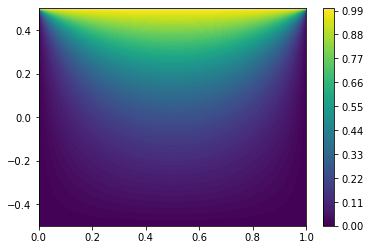

In [190]:
fig,ax = plt.subplots()
contour = ax.contourf(laplace4[0], laplace4[1], laplace4[2], 100)
cbar = fig.colorbar(contour)



The solution converged after 14603 iterations


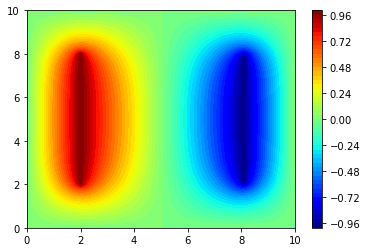

In [206]:
import numpy as np
import matplotlib.pyplot as plt

def f(X,Y):
    return 0*X + 0*Y

boundary = [0,0,0,0]                      #left, right, bottom, up
M=100
xlims=[0,10]
ylims=[0,10]
tolerance = 1e-10
max_it = 100000

nx, ny = M+1, M+1                         # number of points in the x and y direction
#xlims, ylims = np.array(xlims), np.array(ylims)                       
xmin, xmax = xlims[0], xlims[1]           # limits in the x direction
ymin, ymax = ylims[0], ylims[1]           # limits in the y direction
lx, ly = xmax - xmin, ymax - ymin         # domain length in the x, and y direction
dx = lx/(nx-1)                            # grid spacing in the x direction
dy = ly/(ny-1)                            # grid spacing in the y direction

# Create the gridline locations and the mesh grid;
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y, indexing='ij')
p = np.zeros((nx, ny))
p[0,:], p[-1,:], p[:,0], p[:,-1] = boundary[0], boundary[1], boundary[2], boundary[3] #left, right, bottom, up

## I can't explain what's happening on the contour plot when I run this. 
n = M//5 
# p[n, n:-n], p[-n, n:-n] = 1,1
# p[1,1] = 10 
 
pnew = p.copy()
it = 0 # iteration counter
diff = 1.0
tol_hist_jac = []

b = f(X,Y)
while (diff > tolerance):

    #p[n, n:-n], p[-n, n:-n] = 1,-1 
    if it > max_it:
        print('\nSolution did not converge within the maximum'
                ' number of iterations'
                f'\nLast diff was: {diff:.5e}')
        break
    np.copyto(p, pnew)
    pnew[1:-1, 1:-1] = (0.25*(p[:-2, 1:-1]+p[2:, 1:-1]+p[1:-1, :-2]
                    + p[1:-1, 2:]-b[1:-1, 1:-1]*dx**2))

    pnew[n, n:-n], pnew[-n, n:-n] = 1,-1
    diff = np.max(abs(pnew-p))
    # print(diff)
    tol_hist_jac.append(diff)
    it += 1
print(f'\nThe solution converged after {it} iterations')

fig,ax = plt.subplots()
contour = ax.contourf(X,Y, pnew, 50, cmap='jet')
cbar = fig.colorbar(contour)